**Yfinnace version**

The following is a fairly simple Quant. Momentum strategy that can be used to distribute a portfolio between recently high performing stocks

This version, HQ = High Quality, uses various dates, stats, to review longer term safer stocks

In [1]:
# calculation, file creation imports
import numpy as np
import pandas as pd
import requests 
import xlsxwriter
import math
from scipy import stats
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # not sure if this one is actually needed, review required
from forex_python.converter import CurrencyRates
import xlsxwriter as xlsx
import os

#email related imports
import ssl
from email.message import EmailMessage
import smtplib
from email import encoders
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

### getting the SnP 
import bs4 as bs
import pickle

Global Functions:

In [ ]:
# this is how much money to invest
def portfolioIput():
    global portfolioSize
    canContinue = False
    portfolioSize = input('Enter the size of your portfolio (£)')
    while not canContinue:
        try:
            portfolioSize = int(portfolioSize)
            print('portfolioSize: ',portfolioSize)
            canContinue = True
        except:
            portfolioSize = input('Enter the size of your portfolio (£) (must be numeric)') 
#portfolioIput()

# this is how many stocks to spread the investment over
def stockLimitInput():
    global stockLimit
    canContinue = False
    stockLimit = input('How many stocks do you wish to invest in?')
    while not canContinue:
        try:
            stockLimit = int(stockLimit)
            print('stockLimit: ',stockLimit)
            canContinue = True
        except:
            stockLimit = input('How many stocks do you wish to invest in? (needs to be an integer)') 
#stockLimitInput()    

# this is depreciated
def exchange(amount, currency):
    try:  
        rate = CurrencyRates().get_rate('GBP', currency)
    except:
        rate = 1
    return amount * rate
exchange(123, 'USD')

def makeTodaysFolder():
    global today
    today = datetime.today().strftime('%Y-%m-%d')
    try:
        current = os.getcwd()
        os.mkdir(current+ f'/{today}')
    except:
        pass 
#makeTodaysFolder()

def emailWithAttachment(subject, email_receiver, email_receiver_name,  filename):
    # Define email sender and receiver
    email_sender = '** removed from public repo**'
    email_password =  '** removed from public repo**'

    hello = f"Hi {email_receiver_name}, \n\n"
    body = """
    Here are the findings of this months finance calculations, this is not financial advice

    This was an automated email sent via Python, please see 'About & Audit' tab on excel attachment.
    """
    emailText = hello + body

    
    message = MIMEMultipart()
    message['From'] = email_sender
    message['To'] = email_receiver
    message['Subject'] = subject
    message.attach(MIMEText(emailText, "plain"))
    
    #filename = "./2023-12-05/ADBE_2023-09-06_2023-12-05.jpg"
    
    # Open PDF file in binary mode
    
    # We assume that the file is in the directory where you run your Python script from
    with open(filename, "rb") as attachment:
        # The content type "application/octet-stream" means that a MIME attachment is a binary file
        part = MIMEBase("application", "octet-stream")
        part.set_payload(attachment.read())
    
    # Encode to base64
    encoders.encode_base64(part)
    
    # Add header 
    part.add_header(
        "Content-Disposition",
        f"attachment; filename= {filename}",
    )
    
    # Add attachment to your message and convert it to string
    message.attach(part)
    #text = em.as_string()

    # Add SSL (layer of security)
    context = ssl.create_default_context()

    # Log in and send the email
    with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=context) as smtp:
        smtp.login(email_sender, email_password)
        smtp.sendmail(email_sender, email_receiver, message.as_string())

# getting current SNP500 
def get_sp500_tickers():
    global wikiLink
    wikiLink = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    resp = requests.get(wikiLink)
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    global wikiTableRaw
    wikiTableRaw = soup.find('table', {'class': 'wikitable sortable sticky-header'})
    tickers = []
    wikiCols = [title.text.strip() for title in wikiTableRaw.find('tr').findAll('th')] # array of all headings
    wikiCols.append('Link')
    wikiTable = pd.DataFrame(columns=wikiCols)

    for row in wikiTableRaw.findAll('tr')[1:]:
        tmpArr = []
        for colNum, col in enumerate(wikiCols[0:len(wikiCols) - 1]):
            tmpArr.append(row.findAll('td')[colNum].text.strip())
        link = row.find('a', {"class":"external text"}).get("href")
        tmpArr.append(link)
        tmpSeries = pd.Series(tmpArr, index=wikiCols)
        wikiTable.loc[len(wikiTable)] = tmpSeries

    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)

    return wikiTable
##get_sp500_tickers()

Getting the Synbols from the csv:

In [3]:
stockLimitInput() # this sets var stockLimit

stockLimit:  10


In [4]:
portfolioIput() # this to set var portfolioSize50

portfolioSize:  100


In [5]:
#df = pd.read_csv("sp_500_stocks.csv")
#df = pd.read_csv("ftse_250_stocks.csv")

df = get_sp500_tickers()
df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,Link
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,0000066740,1902,https://www.nyse.com/quote/XNYS:MMM
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,0000091142,1916,https://www.nyse.com/quote/XNYS:AOS
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,0000001800,1888,https://www.nyse.com/quote/XNYS:ABT
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888),https://www.nyse.com/quote/XNYS:ABBV
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989,https://www.nyse.com/quote/XNYS:ACN
...,...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,0001524472,2011,https://www.nyse.com/quote/XNYS:XYL
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,0001041061,1997,https://www.nyse.com/quote/XNYS:YUM
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,0000877212,1969,https://www.nasdaq.com/market-activity/stocks/...
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,0001136869,1927,https://www.nyse.com/quote/XNYS:ZBH


Getting the data from yFinance based on the Ticker Symbols

In [6]:
columns = [
    'Ticker', 
    'Company Name',
    'Price', 
    'Currency',
    'Link',
    'Number of Shares to Buy',
    'One-Year Price Return', 
    'One-Year Price Percentile',
    'Six-Month Price Retun',
    'Six-Month Price Percentile',
    'Three-Month Price Retun',
    'Three-Month Price Percentile',
    'One-Month Price Retun',
    'One-Month Price Percentile',
    'Average Percentile'
]
finalDf = pd.DataFrame(columns=columns)
naDf = pd.DataFrame(columns=columns)

#length = df.shape[0]
length = df.shape[0] # set to 30 for testing...
#length = 5
tickerArr = []
#tmpSeries

for i in range(length):
    tmpSym = df.iloc[i,0]
    tickerArr.append(tmpSym)
stringAgg = ' '.join(tickerArr)

oneMonthAgo = (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d')
threeMonthsAgo = (datetime.now() - timedelta(days=90)).strftime('%Y-%m-%d')
sixMonthsAgo = (datetime.now() - timedelta(days=180)).strftime('%Y-%m-%d')

timeFrames = [oneMonthAgo, threeMonthsAgo, sixMonthsAgo]

# example of getting historical data
multi = yf.Tickers(stringAgg)
#multi.tickers['A'].history(start=oneMonthAgo).iloc[0]['Open']
#multi.tickers['A'].history(start=threeMonthsAgo).iloc[0]['Open']
#multi.tickers['A'].history(start=sixMonthsAgo).iloc[0]['Open']


for i in range(length):
    tmpSym = df.iloc[i,0]
    try:
        #dict[tmpSym] = tmpChange
        tmpTic  = multi.tickers[tmpSym]
        curPrice = tmpTic.basic_info.last_price
        tmpSeries = pd.Series([
                        tmpSym, 
                        df.loc[i,'Security'],
                        curPrice,
                        tmpTic.basic_info.currency,
                        df.loc[i,'Link'],
                        'N/A',
                        tmpTic.basic_info.year_change,
                        'X',
                        (curPrice / tmpTic.history(start=sixMonthsAgo).iloc[0]['Open']) - 1,
                        'X',
                        (curPrice / tmpTic.history(start=threeMonthsAgo).iloc[0]['Open']) - 1,
                        'X',
                        (curPrice / tmpTic.history(start=oneMonthAgo).iloc[0]['Open']) - 1,
                        'X',
                        'X'
                    ],
                        index=columns
                    )
        finalDf.loc[len(finalDf)] = tmpSeries
        #print(tmpSeries)
        

    except:
        tmpSeries = pd.Series([
                        tmpSym, 
                        'Price', 
                        'Company Name',
                        'Currency',
                        'Link',
                        'Number of Shares to Buy',
                        'One-Year Price Return',
                        'One-Year Price Percentile',
                        'Six-Month Price Retun',
                        'Six-Month Price Percentile',
                        'Three-Month Price Retun',
                        'Three-Month Price Percentile',
                        'One-Month Price Retun',
                        'One-Month Price Percentile',
                        'Average Percentile'
                    ],
                        index=columns
                    )
        naDf.loc[len(finalDf)] = tmpSeries

finalDf

BF.B: No price data found, symbol may be delisted (1d 2024-06-14 -> 2024-12-11)
STX: No price data found, symbol may be delisted (1d 2024-11-11 -> 2024-12-11)


,Ticker,Company Name,Price,Currency,Link,Number of Shares to Buy,One-Year Price Return,One-Year Price Percentile,Six-Month Price Retun,Six-Month Price Percentile,Three-Month Price Retun,Three-Month Price Percentile,One-Month Price Retun,One-Month Price Percentile,Average Percentile
0,MMM,3M,129.725006,USD,https://www.nyse.com/quote/XNYS:MMM,N/A,0.513309,X,0.304656,X,0.000882,X,-0.032889,X,X
1,AOS,A. O. Smith,73.0,USD,https://www.nyse.com/quote/XNYS:AOS,N/A,-0.081782,X,-0.108909,X,-0.064688,X,-0.027704,X,X
2,ABT,Abbott Laboratories,114.290001,USD,https://www.nyse.com/quote/XNYS:ABT,N/A,0.082677,X,0.117609,X,-0.014346,X,-0.022661,X,X
3,ABBV,AbbVie,174.509995,USD,https://www.nyse.com/quote/XNYS:ABBV,N/A,0.146372,X,0.066375,X,-0.096912,X,-0.022736,X,X
4,ACN,Accenture,365.244995,USD,https://www.nyse.com/quote/XNYS:ACN,N/A,0.057339,X,0.308909,X,0.04637,X,0.028859,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,XYL,Xylem Inc.,123.279999,USD,https://www.nyse.com/quote/XNYS:XYL,N/A,0.191125,X,-0.110933,X,-0.050717,X,-0.007664,X,X
435,YUM,Yum! Brands,138.679993,USD,https://www.nyse.com/quote/XNYS:YUM,N/A,0.079253,X,0.019415,X,0.039397,X,0.019325,X,X
436,ZBRA,Zebra Technologies,403.690002,USD,https://www.nasdaq.com/market-activity/stocks/...,N/A,0.678419,X,0.321451,X,0.191494,X,0.009225,X,X
437,ZBH,Zimmer Biomet,107.169998,USD,https://www.nyse.com/quote/XNYS:ZBH,N/A,-0.077054,X,0.009064,X,0.021476,X,-0.009428,X,X


Adding In Percentile Data:

In [7]:
percentileColumnsX = [column for column in columns if 'Percentile' in column.split(' ')] 
percentileColumnsX

percentileColumns = [
    {
        "return": "One-Year Price Return",
        "percentile": "One-Year Price Percentile"
    },
    {
        "return": "Six-Month Price Retun",
        "percentile": "Six-Month Price Percentile"
    },
    {
        "return": "Three-Month Price Retun",
        "percentile": "Three-Month Price Percentile"
    },
    {
        "return": "One-Month Price Retun",
        "percentile": "One-Month Price Percentile"
    }
]

finalDf.loc[3, 'One-Year Price Percentile'] = 10
finalDf

# Using scipy.stats to work out percentiles 
for row in finalDf.index:
    tmpTotalPercentage = 0
    for col in percentileColumns:
        tmpPercentil = stats.percentileofscore(finalDf[col["return"]], finalDf.loc[row , col["return"]])
        finalDf.loc[row , col["percentile"]] = tmpPercentil
        tmpTotalPercentage += tmpPercentil
    finalDf.loc[row ,"Average Percentile"] = tmpTotalPercentage / len(percentileColumns)

finalDf


,Ticker,Company Name,Price,Currency,Link,Number of Shares to Buy,One-Year Price Return,One-Year Price Percentile,Six-Month Price Retun,Six-Month Price Percentile,Three-Month Price Retun,Three-Month Price Percentile,One-Month Price Retun,One-Month Price Percentile,Average Percentile
0,MMM,3M,129.725006,USD,https://www.nyse.com/quote/XNYS:MMM,N/A,0.513309,86.104784,0.304656,81.776765,0.000882,34.851936,-0.032889,32.574032,58.826879
1,AOS,A. O. Smith,73.0,USD,https://www.nyse.com/quote/XNYS:AOS,N/A,-0.081782,14.350797,-0.108909,11.617312,-0.064688,20.273349,-0.027704,36.67426,20.728929
2,ABT,Abbott Laboratories,114.290001,USD,https://www.nyse.com/quote/XNYS:ABT,N/A,0.082677,33.257403,0.117609,48.974943,-0.014346,30.979499,-0.022661,40.546697,38.439636
3,ABBV,AbbVie,174.509995,USD,https://www.nyse.com/quote/XNYS:ABBV,N/A,0.146372,44.646925,0.066375,38.724374,-0.096912,15.034169,-0.022736,40.091116,34.624146
4,ACN,Accenture,365.244995,USD,https://www.nyse.com/quote/XNYS:ACN,N/A,0.057339,28.929385,0.308909,82.687927,0.04637,49.202733,0.028859,77.448747,59.567198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,XYL,Xylem Inc.,123.279999,USD,https://www.nyse.com/quote/XNYS:XYL,N/A,0.191125,53.986333,-0.110933,11.161731,-0.050717,23.006834,-0.007664,52.61959,35.193622
435,YUM,Yum! Brands,138.679993,USD,https://www.nyse.com/quote/XNYS:YUM,N/A,0.079253,32.801822,0.019415,28.246014,0.039397,46.924829,0.019325,73.348519,45.330296
436,ZBRA,Zebra Technologies,403.690002,USD,https://www.nasdaq.com/market-activity/stocks/...,N/A,0.678419,94.077449,0.321451,84.28246,0.191494,82.004556,0.009225,67.653759,82.004556
437,ZBH,Zimmer Biomet,107.169998,USD,https://www.nyse.com/quote/XNYS:ZBH,N/A,-0.077054,15.034169,0.009064,26.879271,0.021476,41.685649,-0.009428,51.936219,33.883827


Filtering and Ordering:

In [8]:
finalDfFiltered = finalDf.loc[(finalDf['One-Year Price Return'] != 'N/A') & (finalDf['One-Year Price Return'])]
finalDfFilteredOrdered = finalDfFiltered.sort_values('Average Percentile', ascending = False)

finalDfFilteredOrderedLimited = finalDfFilteredOrdered[:stockLimit]
finalDfFilteredOrderedLimited.reset_index(inplace=True, drop=True)

finalDfFilteredOrderedLimited50 = finalDfFilteredOrdered[:50]
finalDfFilteredOrderedLimited50.reset_index(inplace=True, drop=True)

finalDfFilteredOrderedLimited

,Ticker,Company Name,Price,Currency,Link,Number of Shares to Buy,One-Year Price Return,One-Year Price Percentile,Six-Month Price Retun,Six-Month Price Percentile,Three-Month Price Retun,Three-Month Price Percentile,One-Month Price Retun,One-Month Price Percentile,Average Percentile
0,PLTR,Palantir Technologies,72.790001,USD,https://www.nasdaq.com/market-activity/stocks/...,N/A,3.050857,100.0,2.144277,100.0,1.088067,100.0,0.210483,99.544419,99.886105
1,GDDY,GoDaddy,207.800003,USD,https://www.nyse.com/quote/XNYS:GDDY,N/A,0.930726,97.722096,0.508968,96.127563,0.37771,95.671982,0.160894,98.633257,97.038724
2,NFLX,Netflix,936.239014,USD,https://www.nasdaq.com/market-activity/stocks/...,N/A,0.972678,98.177677,0.429263,93.621868,0.366932,95.216401,0.176327,99.088838,96.526196
3,AXON,Axon Enterprise,641.109985,USD,https://www.nasdaq.com/market-activity/stocks/...,N/A,1.634418,99.316629,1.195582,99.77221,0.757043,99.544419,0.049177,86.332574,96.241458
4,RCL,Royal Caribbean Group,245.975006,USD,https://www.nyse.com/quote/XNYS:RCL,N/A,1.042061,98.633257,0.60556,98.177677,0.495601,98.405467,0.069457,89.52164,96.18451
5,BX,Blackstone Inc.,192.509995,USD,https://www.nyse.com/quote/XNYS:BX,N/A,0.674499,93.621868,0.607163,98.405467,0.343308,93.849658,0.072479,90.205011,94.020501
6,FTNT,Fortinet,98.029999,USD,https://www.nasdaq.com/market-activity/stocks/...,N/A,0.764716,96.127563,0.621671,98.633257,0.275602,91.116173,0.060701,88.382688,93.56492
7,WMT,Walmart,94.949997,USD,https://www.nyse.com/quote/XNYS:WMT,N/A,0.874009,97.038724,0.431029,93.849658,0.202051,84.05467,0.117716,96.583144,92.881549
8,CCL,Carnival,26.535,USD,https://www.nyse.com/quote/XNYS:CCL,N/A,0.449495,79.726651,0.641002,98.861048,0.594651,99.088838,0.083061,92.255125,92.482916
9,LYV,Live Nation Entertainment,134.429993,USD,https://www.nyse.com/quote/XNYS:LYV,N/A,0.491894,84.28246,0.518297,96.355353,0.382456,96.127563,0.089826,92.938497,92.425968


Calculate the number of Shares to buy based on portfolio size

In [9]:
curLen = len(finalDfFilteredOrderedLimited.index) # incase there is a differnece between stockLimit and the len of df ??
positionSize = float(portfolioSize) / curLen # this is the amount we have to spend on each stock
for i in range(curLen):
    print(finalDfFilteredOrderedLimited.loc[i, 'Currency'])
    positionSizeConverted = exchange(positionSize, finalDfFilteredOrderedLimited.loc[i, 'Currency'])
    tmpAmount = positionSizeConverted / finalDfFilteredOrderedLimited.loc[i, 'Price']
    finalDfFilteredOrderedLimited.loc[i, 'Currency']
    finalDfFilteredOrderedLimited.loc[i, 'Number of Shares to Buy'] = tmpAmount
finalDfFilteredOrderedLimited # this will return fractional shares, add math.floor when a baller with a huge portfolio 

USD
USD
USD
USD
USD
USD
USD
USD
USD
USD


,Ticker,Company Name,Price,Currency,Link,Number of Shares to Buy,One-Year Price Return,One-Year Price Percentile,Six-Month Price Retun,Six-Month Price Percentile,Three-Month Price Retun,Three-Month Price Percentile,One-Month Price Retun,One-Month Price Percentile,Average Percentile
0,PLTR,Palantir Technologies,72.790001,USD,https://www.nasdaq.com/market-activity/stocks/...,0.137382,3.050857,100.0,2.144277,100.0,1.088067,100.0,0.210483,99.544419,99.886105
1,GDDY,GoDaddy,207.800003,USD,https://www.nyse.com/quote/XNYS:GDDY,0.048123,0.930726,97.722096,0.508968,96.127563,0.37771,95.671982,0.160894,98.633257,97.038724
2,NFLX,Netflix,936.239014,USD,https://www.nasdaq.com/market-activity/stocks/...,0.010681,0.972678,98.177677,0.429263,93.621868,0.366932,95.216401,0.176327,99.088838,96.526196
3,AXON,Axon Enterprise,641.109985,USD,https://www.nasdaq.com/market-activity/stocks/...,0.015598,1.634418,99.316629,1.195582,99.77221,0.757043,99.544419,0.049177,86.332574,96.241458
4,RCL,Royal Caribbean Group,245.975006,USD,https://www.nyse.com/quote/XNYS:RCL,0.040655,1.042061,98.633257,0.60556,98.177677,0.495601,98.405467,0.069457,89.52164,96.18451
5,BX,Blackstone Inc.,192.509995,USD,https://www.nyse.com/quote/XNYS:BX,0.051945,0.674499,93.621868,0.607163,98.405467,0.343308,93.849658,0.072479,90.205011,94.020501
6,FTNT,Fortinet,98.029999,USD,https://www.nasdaq.com/market-activity/stocks/...,0.10201,0.764716,96.127563,0.621671,98.633257,0.275602,91.116173,0.060701,88.382688,93.56492
7,WMT,Walmart,94.949997,USD,https://www.nyse.com/quote/XNYS:WMT,0.105319,0.874009,97.038724,0.431029,93.849658,0.202051,84.05467,0.117716,96.583144,92.881549
8,CCL,Carnival,26.535,USD,https://www.nyse.com/quote/XNYS:CCL,0.376861,0.449495,79.726651,0.641002,98.861048,0.594651,99.088838,0.083061,92.255125,92.482916
9,LYV,Live Nation Entertainment,134.429993,USD,https://www.nyse.com/quote/XNYS:LYV,0.074388,0.491894,84.28246,0.518297,96.355353,0.382456,96.127563,0.089826,92.938497,92.425968


**xlsxwriter section:**

Creates xlsx file with attachments and emails results as an attachment

C:\Users\benhu\AppData\Local\Temp\ipykernel_16084\3040697152.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,4))


Workbook is awaiting


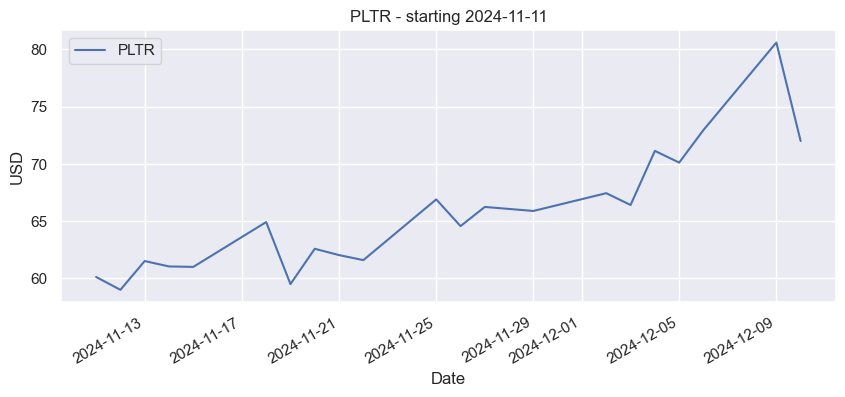

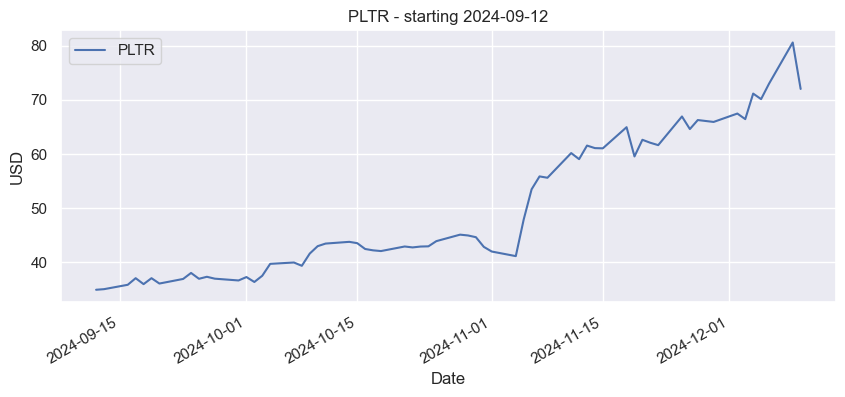

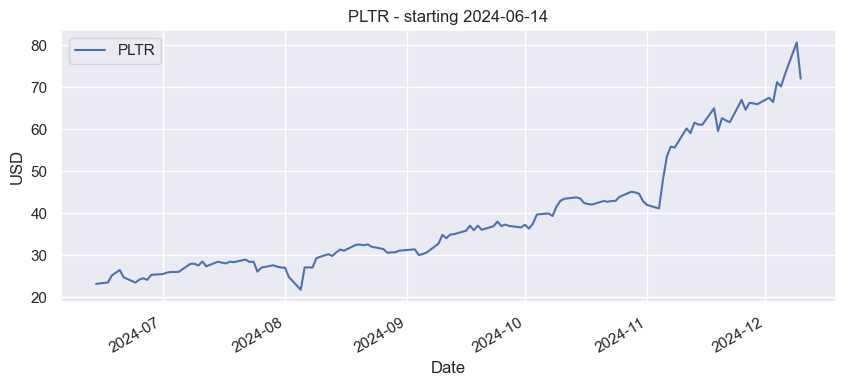

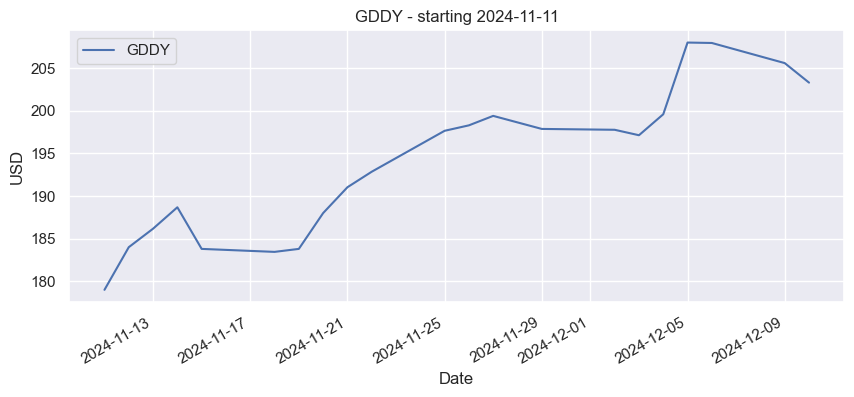

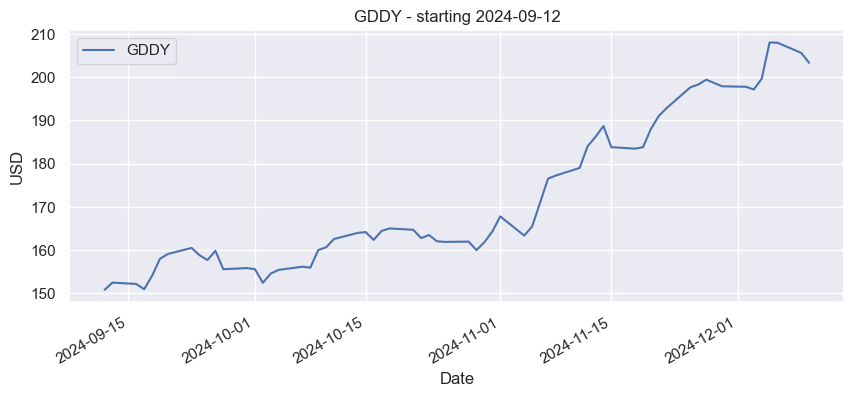

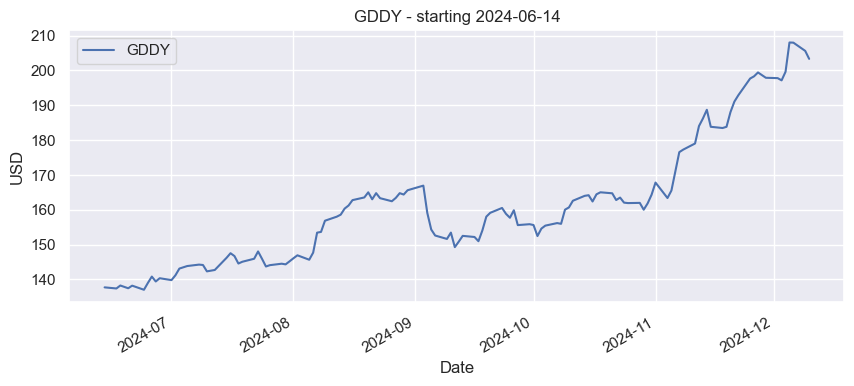

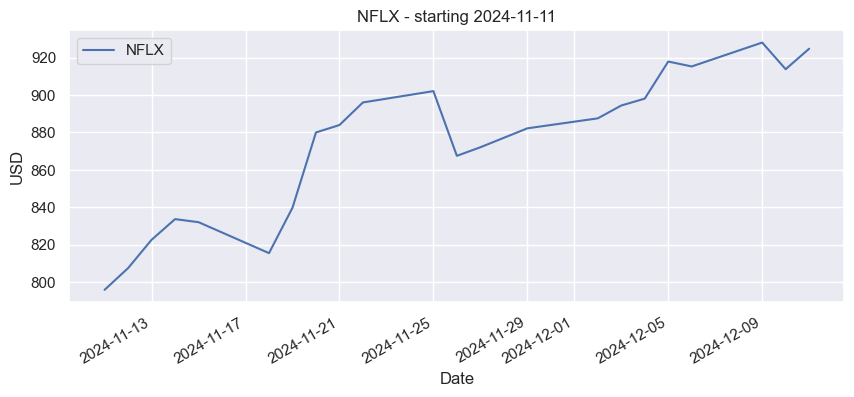

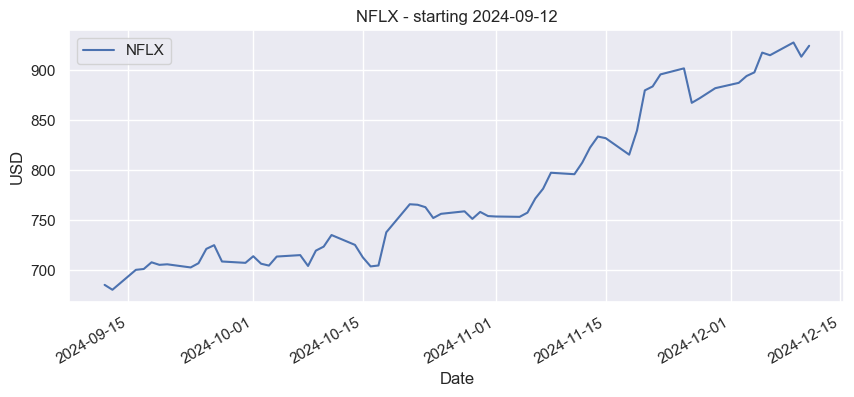

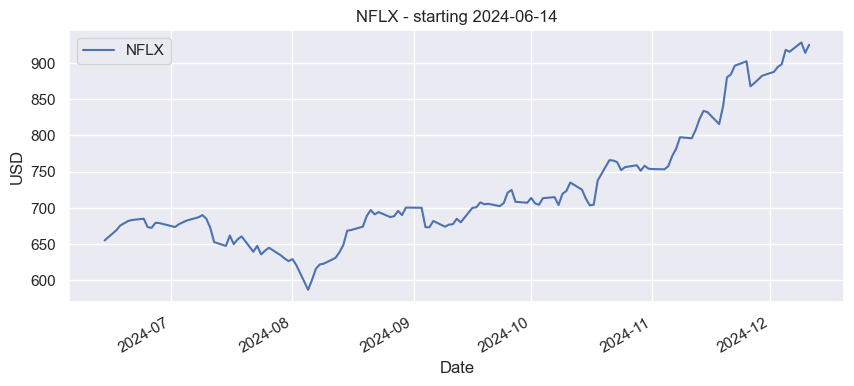

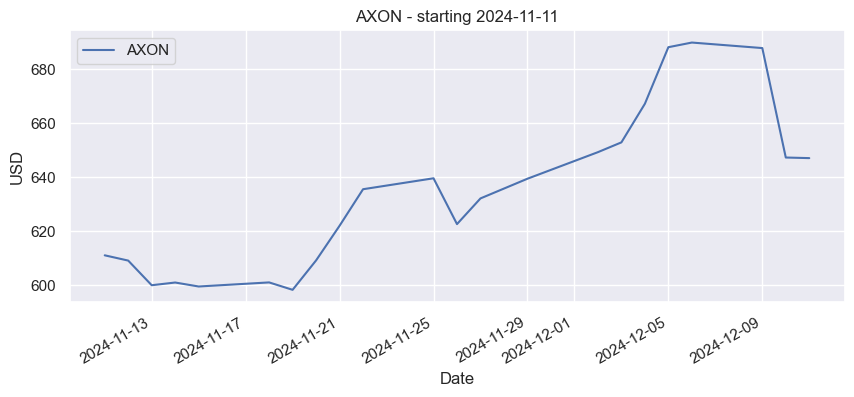

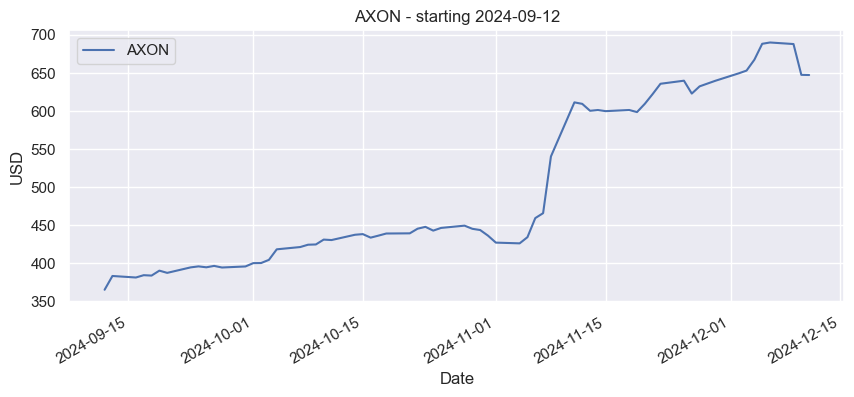

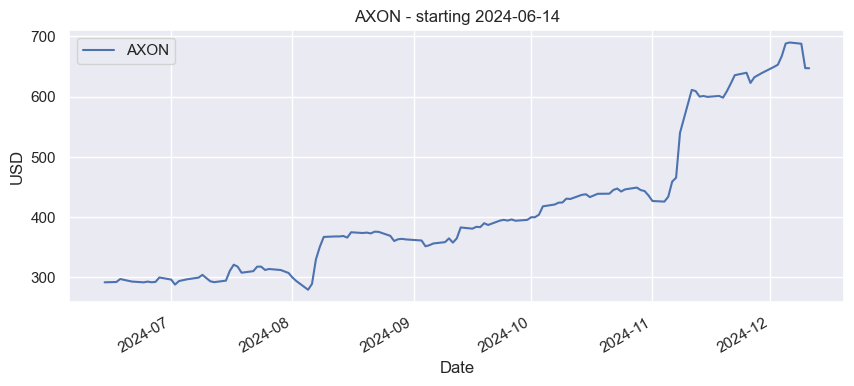

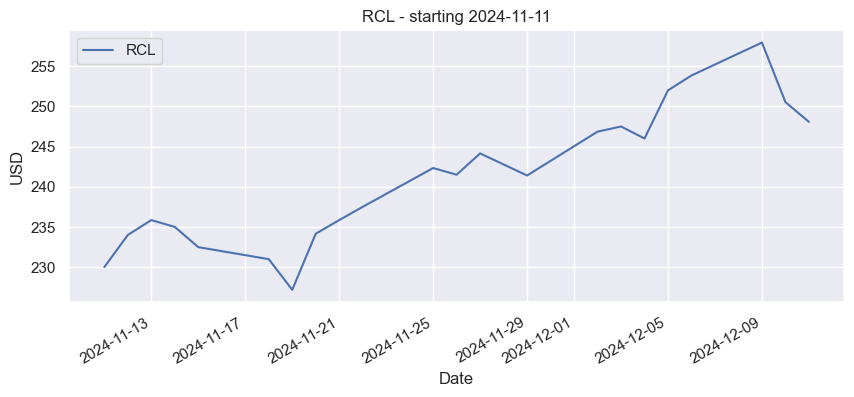

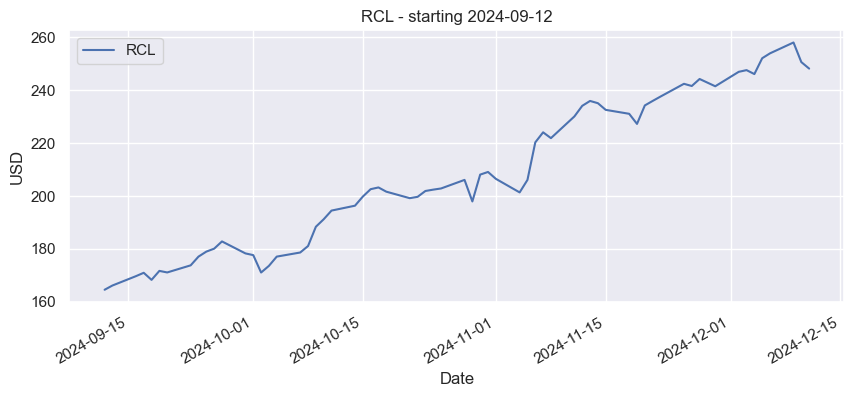

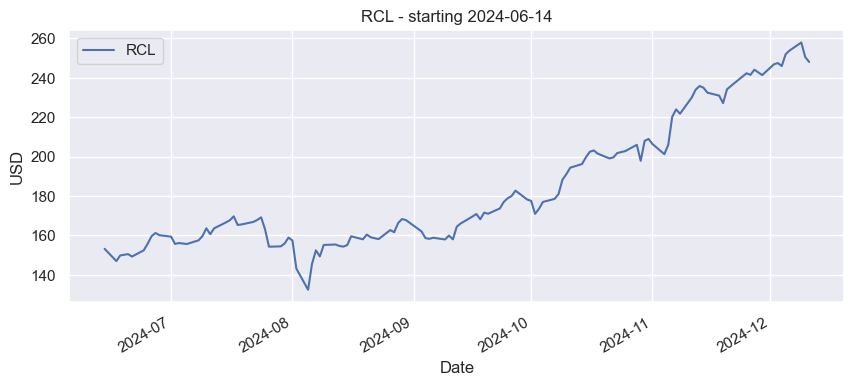

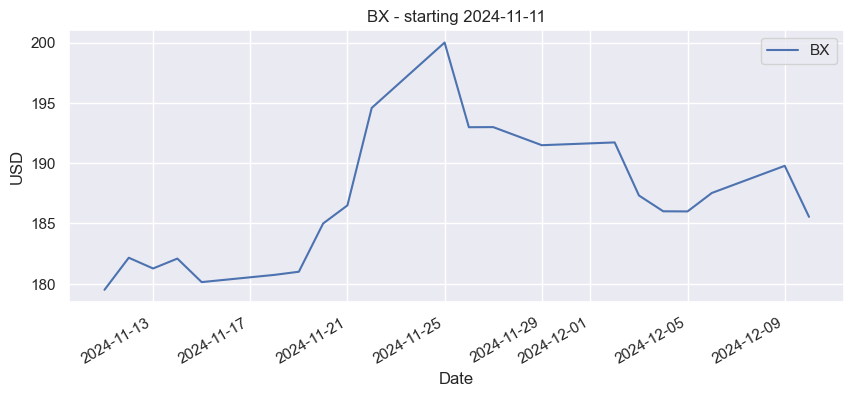

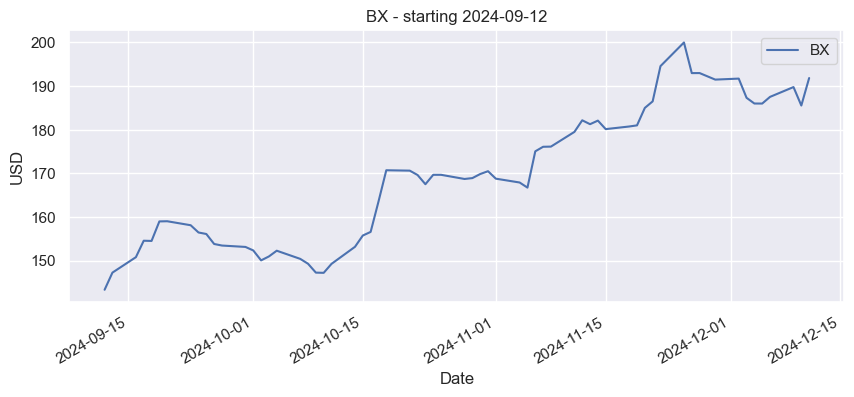

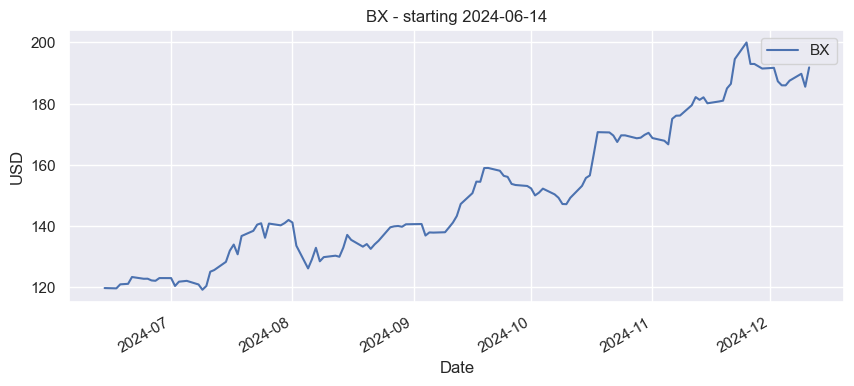

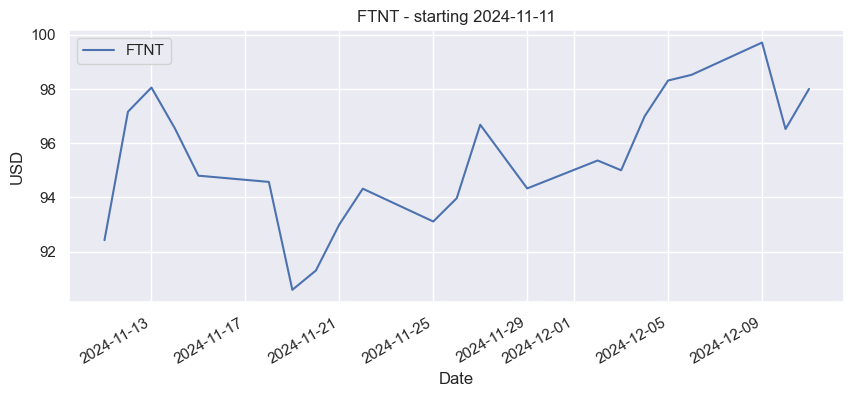

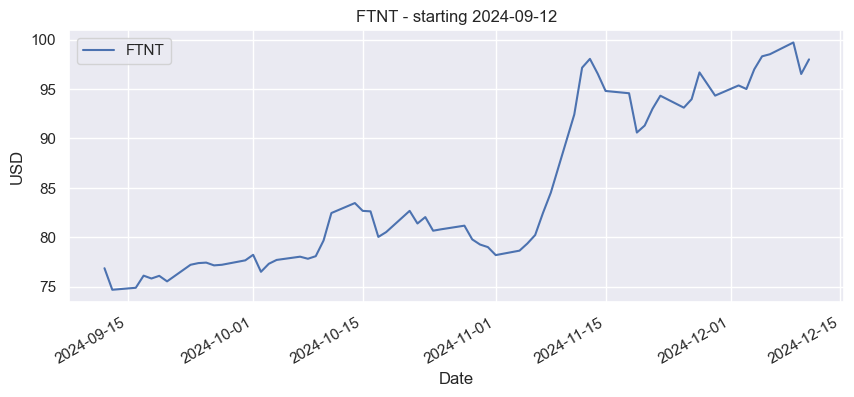

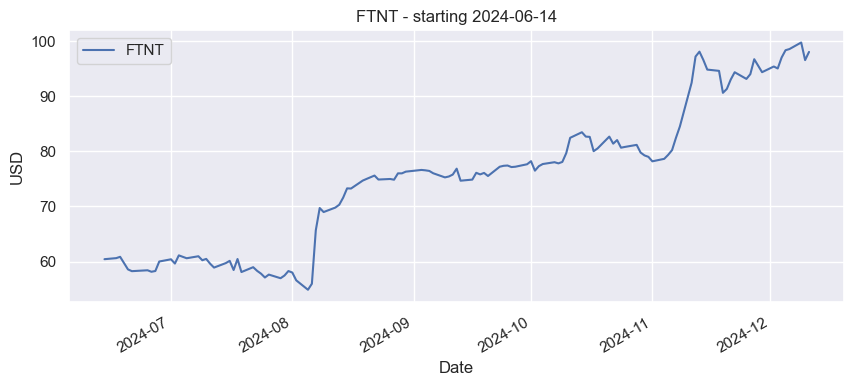

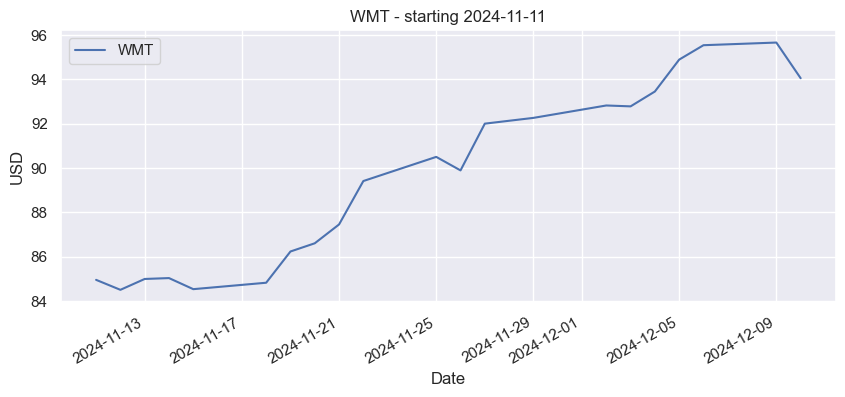

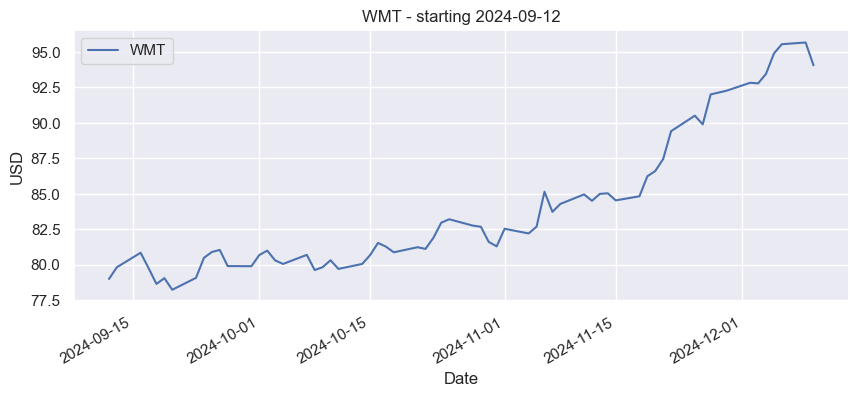

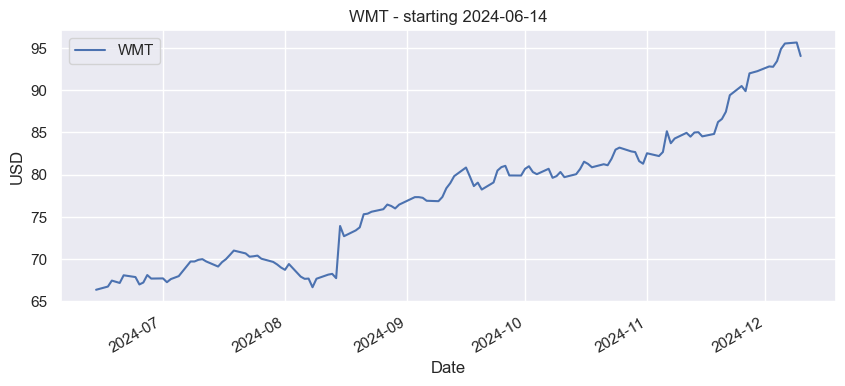

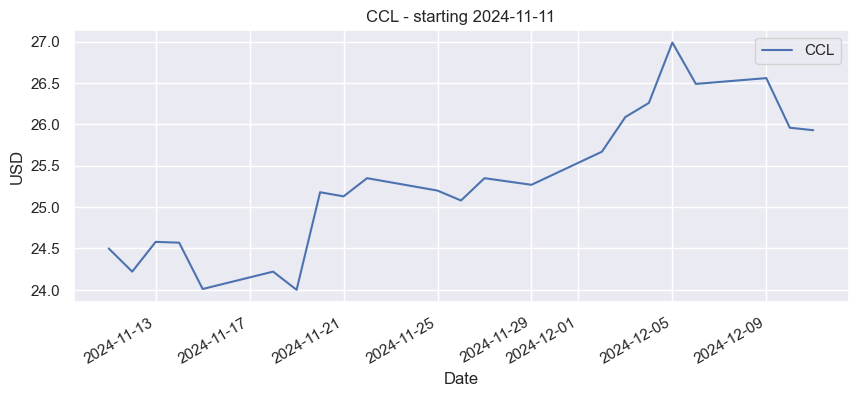

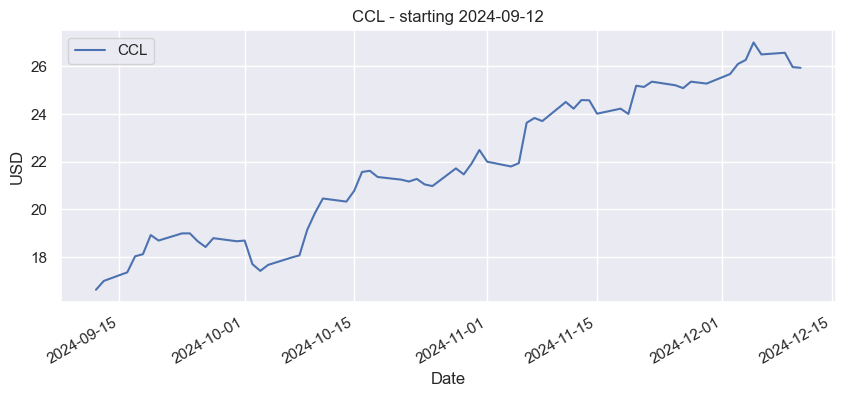

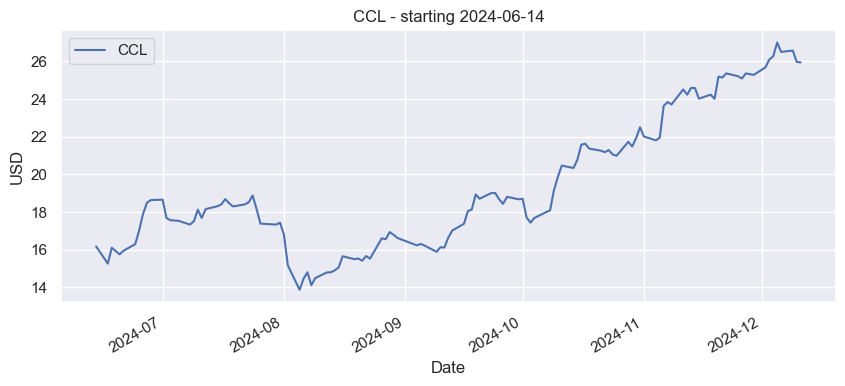

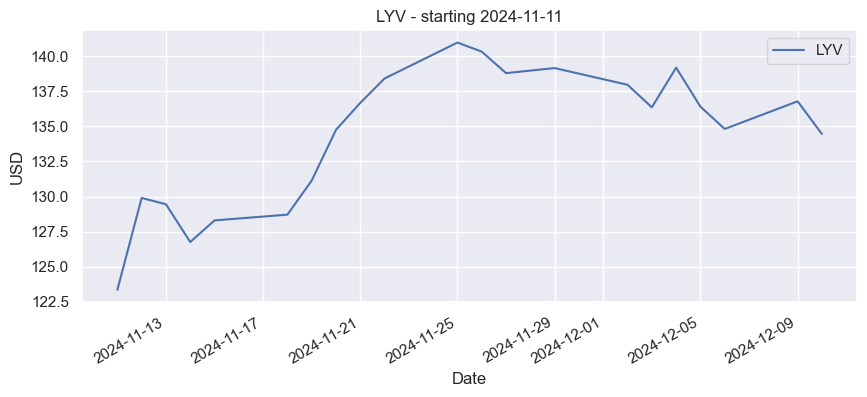

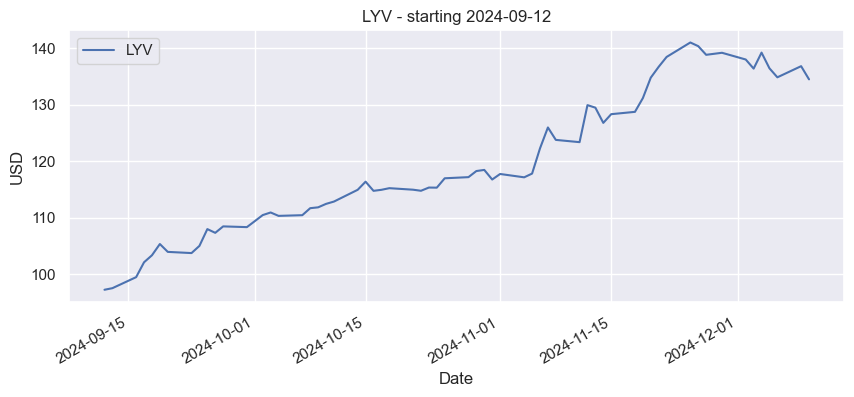

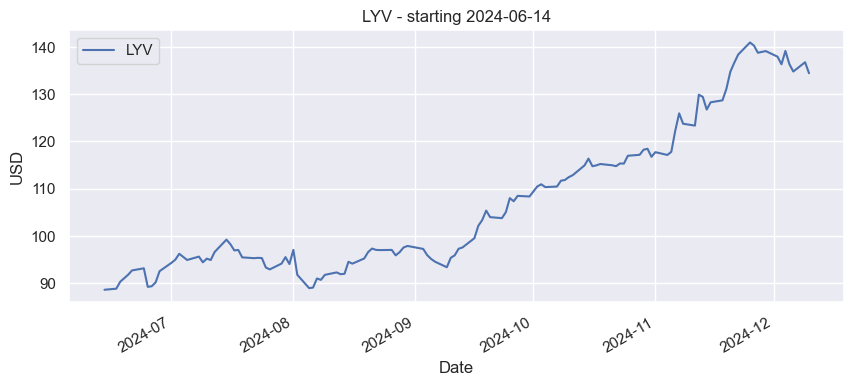

In [10]:
makeTodaysFolder() # also creates global variable of today
fileName = f"./{today}/stock_report_{today}.xlsx"
writer = pd.ExcelWriter(fileName , engine="xlsxwriter")

# creating the top 50 sheet
top50sheetName = 'Top 50'
finalDfFilteredOrderedLimited50.to_excel(writer, sheet_name=top50sheetName)
worksheet = writer.sheets[top50sheetName]
for colnum, column in enumerate(finalDfFilteredOrderedLimited50.columns):
    len(list(column))
    worksheet.set_column(colnum + 1, colnum + 1, len(list(column)) + 1)



# creating the individual stock sheets
for ticker in finalDfFilteredOrderedLimited['Ticker']:
    # iterating throuhg the top 
    mainDf = finalDfFilteredOrderedLimited
    mainDf.loc[mainDf['Ticker'] == ticker].to_excel(writer, sheet_name=ticker)  # Default position, cell A1.
    worksheet = writer.sheets[ticker]

    # setting column widths of the sheet
    for colnum, column in enumerate(mainDf.columns):
        len(list(column))
        worksheet.set_column(colnum + 1, colnum + 1, len(list(column)) + 1)

    worksheet.set_column(0,0,3)

        #link  = str(mainDf.loc[mainDf.Ticker == ticker, 'Link'][0])
        #print(link)
        #worksheet.write(3, 0, link)

    
    for index, date in enumerate(timeFrames):
        # creating, saving and inserting the files into the sheet
        plt.figure(figsize=(10,4))
        yf.Ticker(ticker).history(start=date)['Open'].plot()
        plt.title(f'{ticker} - starting {date}')
        plt.legend([ticker])
        plt.ylabel(yf.Ticker(ticker).basic_info['currency'])
        imageFileName = f"{today}/{ticker}_{date}_{today}.jpg"
        plt.savefig(imageFileName)
        worksheet.insert_image("A" + str(4 + 17 * index), imageFileName, {"x_scale": 0.75, "y_scale": 0.75})
        #plt.show()


#creating the About / Audit
helpAuditSheetName = 'About & Audit'
worksheet = writer.book.add_worksheet(helpAuditSheetName)
worksheet.set_column(0,0,100)

autitMessages = [
    F'This is not financial advice',
    f'Nuber of stocks selected to invest in: {stockLimit}',
    f'Selected Portfolio Size (£): {portfolioSize}',
    f'Tickers evalueted via: {wikiLink}',
    f'Stock data added via the yFinance python library',
    f'This was run on: {datetime.now().strftime("%d/%m/%Y %H:%M:%S")}'
    
]

for index, message in enumerate(autitMessages):
    worksheet.write(index,0,message)


writer.close()
print('Workbook is awaiting')

In [ ]:
emailSubject = f'{today} - Quantitative Momentum Report'
mailingCols = ['Name', 'Email', 'Active']
mailingListData = [
    ['Ben', 'ben.hunt19@hotmail.com', False]
]
#building the dataframe to store the data, does't need to be a DataFrame but could be useful for expansion
mailingDf = pd.DataFrame(columns=mailingCols)
for j in range(len(mailingListData)):
    mailingDf.loc[len(mailingDf)] = pd.Series(mailingListData[j], index=mailingCols)

for i in range(len(mailingDf)):
    if mailingDf.loc[i]['Active']:
        emailWithAttachment(emailSubject, mailingDf.loc[i]['Email'], mailingDf.loc[i]['Name'], fileName)